# Context

This dataset contains images of the following food items:

- **fruits**: banana, apple, pear, grapes, orange, kiwi, watermelon, pomegranate, pineapple, mango
- **vegetables**: cucumber, carrot, capsicum, onion, potato, lemon, tomato, raddish, beetroot, cabbage, lettuce, spinach, soy bean, cauliflower, bell pepper, chilli pepper, turnip, corn, sweetcorn, sweet potato, paprika, jalepeño, ginger, garlic, peas, eggplant

# Content
This dataset contains three folders:

- train (100 images each)
- test (10 images each)
- validation (10 images each)
each of the above folders contains subfolders for different fruits and vegetables wherein the images for respective food items are present

# Note
This notebook is wholly using elements found in https://www.kaggle.com/code/jiaowoguanren/fruits-and-vegetables-image-recognition-dataset-tf.

In [1]:
import cv2
import matplotlib.pyplot as plt
import pathlib, os, random, math
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras import Sequential

In [2]:
epochs = 30
batch_size = 32
img_height, img_width = 300, 300
input_shape = (img_height, img_width, 3)
data_gen = ImageDataGenerator(rescale=1.0 / 255)

train_ds = data_gen.flow_from_directory('../raw_data/fruits_and_vegetables_image_recognition_dataset/train', target_size=(img_height, img_width),
                                            class_mode='sparse', batch_size=batch_size, subset='training')
val_ds = data_gen.flow_from_directory('../raw_data/fruits_and_vegetables_image_recognition_dataset/test', target_size=(img_height, img_width),
                                          class_mode='sparse', batch_size=batch_size, shuffle=False)

Found 3115 images belonging to 36 classes.
Found 359 images belonging to 36 classes.


In [4]:
class BaseModel(tf.keras.Model):
    def __init__(self):
        super(BaseModel, self).__init__()
        self.C1 = Conv2D(32, (3 * 3), padding='same', input_shape=input_shape)
        self.B1 = BatchNormalization()
        self.A1 = Activation('relu')
        self.P1 = MaxPooling2D(2, padding='same')
        
        self.C2 = Conv2D(32, (3 * 3), padding='same')
        self.B2 = BatchNormalization()
        self.A2 = Activation('relu')
        self.P2 = MaxPooling2D(2, padding='same')
        self.Dr1 = Dropout(0.2)
        
        self.C3 = Conv2D(64, (3 * 3), padding='same')
        self.B3 = BatchNormalization()
        self.A3 = Activation('relu')
        self.P3 = MaxPooling2D(2, padding='same')
        self.Dr2 = Dropout(0.3)
        
        self.F1 = Flatten()
        self.D1 = Dense(256, activation='relu')
        self.B4 = BatchNormalization()
        self.D2 = Dense(256, activation='relu')
        self.D3 = Dense(256, activation='relu')
        self.D4 = Dense(36, activation='softmax')
        
        
    def call(self, x):
        x = self.C1(x)
        x = self.B1(x)
        x = self.A1(x)
        x = self.P1(x)
        
        x = self.C2(x)
        x = self.B2(x)
        x = self.A2(x)
        x = self.P2(x)
        x = self.Dr1(x)
        
        x = self.C3(x)
        x = self.B3(x)
        x = self.A3(x)
        x = self.P3(x)
        x = self.Dr2(x)
        
        x = self.F1(x)
        x = self.D1(x)
        x = self.B4(x)
        x = self.D2(x)
        x = self.D3(x)
        y = self.D4(x)
        return y
    
    
    def __repr__(self):
        return 'Huang_Model'
    

net = BaseModel()

net.compile(optimizer='adam',
           loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
           metrics=['sparse_categorical_accuracy'])

checkpoint_save_path = './Model.ckpt'
if os.path.exists(checkpoint_save_path + '.index'):
    net.load_weights(checkpoint_save_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_save_path, save_best_only=True, save_weights_only=True)    

history = net.fit(train_ds, epochs=epochs, batch_size=batch_size, validation_data=val_ds, callbacks=[cp_callback])

net.summary()

file = open('./Weights.txt', 'w')
for v in net.trainable_variables:
    file.write(str(v.name) + '\n')
    file.write(str(v.shape) + '\n')
    file.write(str(v.numpy()) + '\n')

file.close()

Epoch 1/30
 2/98 [..............................] - ETA: 9:55 - loss: 3.6767 - sparse_categorical_accuracy: 0.0312 

/Users/postboxes/.pyenv/versions/3.8.12/envs/whats_for_dinner/lib/python3.8/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


98/98 [==============================] - 602s 6s/step - loss: 2.9208 - sparse_categorical_accuracy: 0.1756 - val_loss: 3.5013 - val_sparse_categorical_accuracy: 0.1560
Epoch 2/30
98/98 [==============================] - 594s 6s/step - loss: 2.3200 - sparse_categorical_accuracy: 0.3069 - val_loss: 2.0464 - val_sparse_categorical_accuracy: 0.3872
Epoch 3/30
98/98 [==============================] - 594s 6s/step - loss: 2.0940 - sparse_categorical_accuracy: 0.3708 - val_loss: 1.5491 - val_sparse_categorical_accuracy: 0.5153
Epoch 4/30
98/98 [==============================] - 595s 6s/step - loss: 1.8531 - sparse_categorical_accuracy: 0.4266 - val_loss: 1.4948 - val_sparse_categorical_accuracy: 0.5794
Epoch 5/30
98/98 [==============================] - 593s 6s/step - loss: 1.6690 - sparse_categorical_accuracy: 0.4751 - val_loss: 1.1627 - val_sparse_categorical_accuracy: 0.6072
Epoch 6/30
98/98 [==============================] - 594s 6s/step - loss: 1.4456 - sparse_categorical_accuracy: 0.560

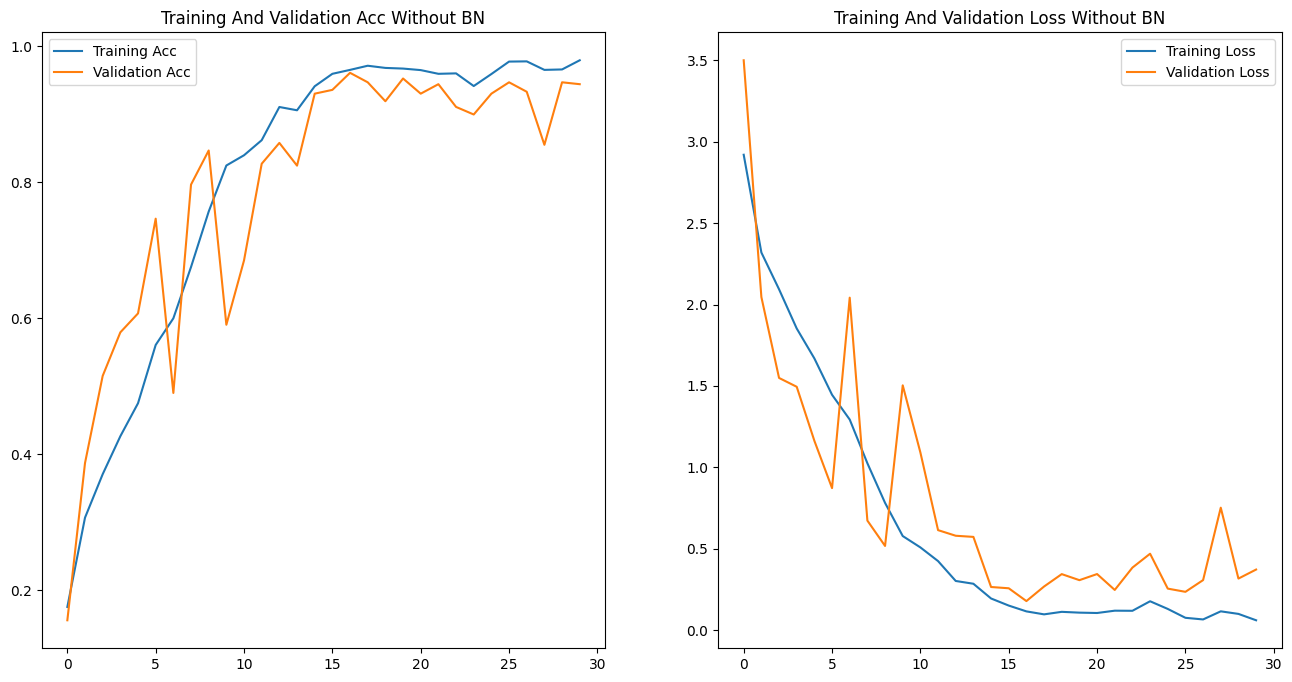

In [5]:
acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Acc')
plt.plot(val_acc, label='Validation Acc')
plt.title('Training And Validation Acc Without BN')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training And Validation Loss Without BN')
plt.legend()

plt.show()